<a href="https://colab.research.google.com/github/soyudea/StrokePredictionModel/blob/main/04_modelo_DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score

**Carga del dataset**  https://www.kaggle.com/competitions/playground-series-s3e2/data?select=train.csv

In [ ]:
#Lectura del dataSet
#==============================================================
datos = pd.read_csv('train.csv', sep=",")
datos_test = pd.read_csv('test.csv', sep=",")
df =datos.copy()
df_test=datos_test.copy()

**Se agregan valores nulos al 5 % de las muestras en los campos age, avg_glucose_level**

In [ ]:
#Se adiciona valores nulos al atributo age y avg_glucose_level
#=============================================================
#df =datos.copy()
lista=[]
porc_nulos =int(np.shape(df)[0]*5/100)   #Calculo de porcentaje de datos nulos
rango_df = np.shape(df)[0]

for i in range(porc_nulos):
    num_aleatprio = np.random.randint(rango_df) 
    lista.append(num_aleatprio)


for i in lista:
    df.at[i, "age"] = np.nan

lista=[]
rango_df = np.shape(df)[0]

for i in range(porc_nulos):
    num_aleatprio = np.random.randint(rango_df) 
    lista.append(num_aleatprio)


for i in lista:
    df.at[i, "avg_glucose_level"] = np.nan

**Estado del dataset despues de agregar valores nulos**

In [ ]:
df.isna().sum().sort_values()

id                     0
gender                 0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
bmi                    0
smoking_status         0
stroke                 0
age                  746
avg_glucose_level    751
dtype: int64

**Se agregan valores promedios en aquellas muestras con valores nulos**

In [ ]:
#Se agregan valores promedios al atributo age cuando son nulos
#==================================================================

mean_age = df['age'].mean().astype(int) #Calculo media de las edades

for i in range(len(df)):
    if math. isnan(df.at[i, "age"]):
       df.at[i, "age"] = mean_age

In [ ]:
#Se agrega valores promedios al atributo avg_glucose_level cuando son nulos
#===============================================================================================
mean_avg_glucose_level = df['avg_glucose_level'].mean().astype(int) #Calculo media de las edades

for i in range(len(df)):
    if math. isnan(df.at[i, "avg_glucose_level"]):
       df.at[i, "avg_glucose_level"] = mean_avg_glucose_level

**Estado final del dataset despues de reemplazar valores nulos con valores promedios**

In [ ]:
datos['age'] = datos['age'].astype('int64') 
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  int64  
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 1.4+ MB


In [ ]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Discretización de las variables 'age', 'avge_glucose_level', 'bmi'**

In [ ]:
#Se transforma campo numerico age a un atributo con valores categoricos, se discretisa
#========================================================================================================================================================

df = datos.copy()

edades = pd.cut(df['age'], bins = [0,10,20,40,np.inf], labels =['niño','joven','adulto','mayor'], include_lowest=True, retbins = True)
df['new_age'] = list(edades[0]) 

glucosa = pd.cut(df['avg_glucose_level'], bins = [0,100,125,np.inf], labels = ['normal', 'prediabetico','diabetico'], include_lowest=True, retbins=True)
df["avg_glucose"] = list(glucosa[0])

im = pd.cut(df['bmi'], bins = [18.5,24.9,25,29.9,np.inf], labels = ['low_weight', 'Healthy_weight','overweight','obesity'], include_lowest=True, retbins=True)
df['bmi_range'] = list(im[0])
df.shape

(15304, 15)

**Transformación del dataset, de variables categoricas a númericas**

In [ ]:
#Se obtiene un dataset con todos sus atributos numéricos
#========================================================================================================================================================================================================================================

vnumericas = df.drop(["id","avg_glucose_level","age","bmi","new_age","avg_glucose","bmi_range","gender","ever_married","work_type","Residence_type","smoking_status", "bmi_range"],axis=1)#SE crea variable númerica sin las categoricas 
vcategoricas=df.filter(["new_age","avg_glucose","bmi_range","gender","ever_married","work_type","Residence_type","smoking_status", "bmi_range"]) 

cat_numerica=pd.get_dummies(vcategoricas,drop_first=False) 
df=pd.concat([cat_numerica,vnumericas],axis=1)
#datos = df
df.shape

(15304, 34)

**Organización del dataset final**

In [ ]:
X = df[:len(df)]
y = df['stroke']
X = X.drop(columns=['stroke'])
X.columns
X.shape

(15304, 33)

**Generador de muestras sintéticas**

In [ ]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409,) (2935, 30) (2935,)


**Calculo pesos de la clase Parametro que se usa para minimizar el efecto del desbalance del dataset**

In [ ]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**Modelo DecisionTreeClassifier https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html**

In [ ]:
#Entrenamiento del modelo  DecisionTreeClassifier con el 90% de las muestras
#=================================================================================================================
kf = KFold(n_splits=20, random_state = True,shuffle=True)

preds = []
scores = []

weight= dar_peso_clase()

classifier = DecisionTreeClassifier(criterion='gini', 
                                    ccp_alpha=0.0000001,
                                    min_samples_split=10,
                                    class_weight= {0: weight[0], 1: weight[1]},
                                    random_state=42,
                                    max_features="sqrt",min_impurity_decrease=0.0
                                    )  #"log2"
                                
X_test =0
y_test =0
for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]  #linea de código para pca
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #modelo = LassoCV(**model_params)
    modelo = classifier.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print()
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits =4, labels=[0,1]))
    preds.append(modelo.predict(X_test))
    s = roc_auc_score(y_test, modelo.predict(X_test))
    print(f'Best val auc: {s: .4f}')
    scores.append(s)
    print()


[[478 174]
 [ 74 595]]
              precision    recall  f1-score   support

           0     0.8659    0.7331    0.7940       652
           1     0.7737    0.8894    0.8275       669

    accuracy                         0.8123      1321
   macro avg     0.8198    0.8113    0.8108      1321
weighted avg     0.8192    0.8123    0.8110      1321

Best val auc:  0.8113


[[472 166]
 [ 78 605]]
              precision    recall  f1-score   support

           0     0.8582    0.7398    0.7946       638
           1     0.7847    0.8858    0.8322       683

    accuracy                         0.8153      1321
   macro avg     0.8214    0.8128    0.8134      1321
weighted avg     0.8202    0.8153    0.8140      1321

Best val auc:  0.8128


[[468 157]
 [ 71 625]]
              precision    recall  f1-score   support

           0     0.8683    0.7488    0.8041       625
           1     0.7992    0.8980    0.8457       696

    accuracy                         0.8274      1321
   macro a

**Curva ROC para el DecisionTreeClassifier**

Sin entrenar: ROC AUC=0.500
Algoritmo arbol de: ROC AUC=0.816



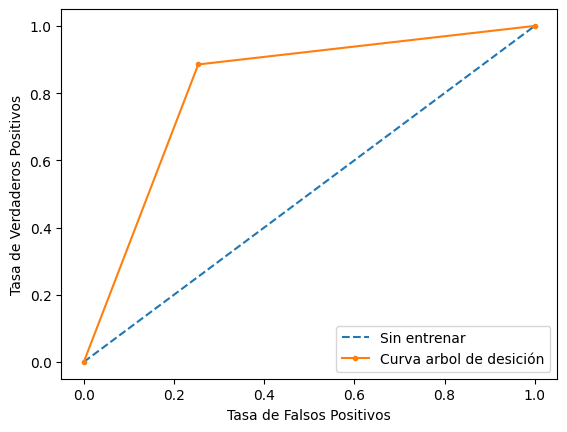

In [ ]:
#Curva ROC Arbol de desición

classes = classifier.predict(X_test) 
ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs,average='weighted')
classifier_auc = roc_auc_score(y_test,classes,average='weighted')

#aps = average_precision_score(y_test, ns_probs)
#print("Average_presicion_score "+str(aps))

print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo arbol de: ROC AUC=%.3f' % (classifier_auc))
classifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
classifier_fpr, classifier_tpr, _ = roc_curve(y_test, classifier_probs)
print()
pyplot.plot(classifier_fpr, classifier_tpr, marker='.', label='Curva arbol de desición')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()
print()